# prerequisite

參考了[這篇](https://forums.fast.ai/t/nameerror-name-timm-is-not-defined/96158) 裝 timm，不然之後訓練 `convnextv2_tiny` 時會報錯 `name 'timm' is not defined`

In [22]:
!pip install -Uqq fastai nbdev timm ipywidgets gradio

In [23]:
from fastai.vision.all import *
from fastai.basics import *
import nbdev
import graphviz
import timm
from ipywidgets import interact
import gradio as gr

`torch.linspace()`：產生等距的數值列表 (rank-1 tensor)

In [24]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

In [25]:
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
  x = torch.linspace(min,max, 100)[:,None]
  if ylim: plt.ylim(ylim)
  plt.plot(x, f(x), color)
  if title is not None: plt.title(title)
  plt.show() # 要加這一項才不會之後透過 ipywidgets 互動調參數時, 每次更新都產生新的 plot

# 知識點

## python 單星號、雙星號用法


- 用於 function call 引數時
	- \* 將引數 tuple/list 展開為 positional 參數
	- ** 將引數 dictionary 展開為 keyword 參數
- 用於 function definition 參數時
	- \* 將 positional 參數打包成為 tuple
	- ** 將 keyword 參數打包成為 dictionary

<pre>
            In function *construction*      In function *call*
=======================================================================
          |  def f(*args):                 |  def f(a, b):
*args     |      for arg in args:          |      return a + b
          |          print(arg)            |  args = (1, 2)
          |  f(1, 2)                       |  f(*args)
----------|--------------------------------|---------------------------
          |  def f(a, b):                  |  def f(a, b):
**kwargs  |      return a + b              |      return a + b
          |  def g(**kwargs):              |  kwargs = dict(a=1, b=2)
          |      return f(**kwargs)        |  f(**kwargs)
          |  g(a=1, b=2)                   |

-----------------------------------------------------------------------
</pre>

([參考](https://e8859487.pixnet.net/blog/post/403127384-%5Bpython%5D-%2A%2A-%E9%9B%99%E6%98%9F%E8%99%9F%28double-star-asterisk%29-vs-%2A%E5%96%AE%E6%98%9F%E8%99%9F%28st))

## 訓練調優

提升準確率的方法：
- 更多 epoch
- image augmentation
- 以其他 model 訓練

### timm

[Pytorch Image Model (timm) 的分析](https://www.kaggle.com/code/jhoward/which-image-models-are-best?scriptVersionId=132442123&cellId=14)

model 效能評估：
- inference 速度
- 準確率
- 記憶體用量

幾種 model：
- resnet18：小、快，適合 prototyping
- resnet34：普遍使用
- levit：快、準，但在 pet breed classifier 表現不好
- convnext：85% 準確率
  - tiny：model 小，對應於記憶體用量小、快

由於 timm 不是 fastai 直接提供的 model, 創建 learner 時的 model 參數要帶字串，如 `vision_learner(dls, 'convnextv2_tiny')`

## `Learner` object

- 數據集的處理設定：`DataLoaders`
- 訓練好的 model
  - layer tree
    - (0): TimmBody
      - (model)
        - (stem)
          - (0): Conv2d
          - (1): LayerNorm2d
        - (stages)
          - (0)
          - (1)
          - (2)
          - ...
    - (1): Sequential

module：繼承自 PyTorch `nn.Module` class，其 object 像 python function 一樣，帶入輸入呼叫後回傳 activation
- 包含 parameter (weight、bias)，負責初始 parameter、計算 activation

## NumPy array vs. PyTorch tensor

NumPy array、PyTorch tensor 本質上是多維陣列；但 PyTorch 支援使用 GPU、計算 gradient，更適合 deep learning
- PyTorch tensor 是規則形狀陣列
- 使用 PyTorch 時，盡量使用它提供的操作，效能會比較好

兩者操作基本都是相同的

PyTorch 中，所有值都是 tensor，允許計算微分等操作
- 0d-tensor (rank-0 tensor)：scalar
- 1d-tensor：vector
- 2d-tensor：matrix
- 3d-tensor：matrix 列表

每一維度稱為 axis/dimension，dimension 的數量稱為 rank

### 創建

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [ ]:
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

### 索引

In [ ]:
tns[1] # 0-indexed, 表示第二列

tensor([4, 5, 6])

: 指代整個 axis

In [ ]:
tns[:,1]

tensor([2, 5])

Python slice 語法 [start:end] (不含 end)

In [ ]:
tns[1,1:3]

tensor([5, 6])

### 標準運算

+, -, *, /

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

### tensor type

tensor 有 type，會根據需要自動更改 type

In [ ]:
tns.type()

'torch.LongTensor'

In [ ]:
(tns*1.5).type()

'torch.FloatTensor'

### 擴展 tensor 的 dimension

In [ ]:
n = torch.rand(3, 100, 100) # 3x100x100
print(n[:, None].shape) # 新增第二個 dimension, 等同 n.unsqueeze(dim=1)
print(n[..., None].shape) # 新增最後一個 dimension; 等同 n.unsqueeze(dim=-1)
print(n[..., None, :].shape) # 新增倒數第二個 dimension; 等同 n.unsqueeze(dim=-2)

torch.Size([3, 1, 100, 100])
torch.Size([3, 100, 100, 1])
torch.Size([3, 100, 1, 100])


### broadcasting

broadcasting：對兩個不同 rank 的 tensor 做運算時，PyTorch 會擴充 (假的複製，不配置額外記憶體) 較小的 tensor 使 rank 一致
- NumPy 也有類似的概念

In [ ]:
tensor1 = torch.tensor([[1, 2], [0, 3]])
tensor2 = torch.tensor([[3, 1]])

print(tensor1 + tensor2)

tensor([[4, 3],
        [3, 4]])


### 矩陣乘法

多個數字的線性組合，簡潔的符號表示，適合 GPU 運算

@ operator：矩陣乘法

[線上工具](http://matrixmultiplication.xyz/)

In [ ]:
m1 = torch.tensor([[1, 2],
          [3, 4]])
m2 = torch.tensor([[5, 6],
          [7, 8]])
m1@m2

tensor([[19, 22],
        [43, 50]])

## PyTorch autograd

autograd：給定函數呼叫，無論內部的複雜合成關係，PyTorch 會自動提供該函數相對於其輸入 parameter 的 gradient

`torch.tensor()` 建構式帶參數 `requires_grad=True`、`tensor.requires_grad_()`：告知跟踪由此 tensor 操作產生的計算 (computational graph)，之後參與計算後，需要計算對此 tensor (在此 tensor 值) 的 gradient

`tensor.grad`：gradient 資訊，包含數值部分和相關的計算圖等信息，初始時為 None
- `tensor.grad.data`：gradient tensor (數值部分)

computational graph：

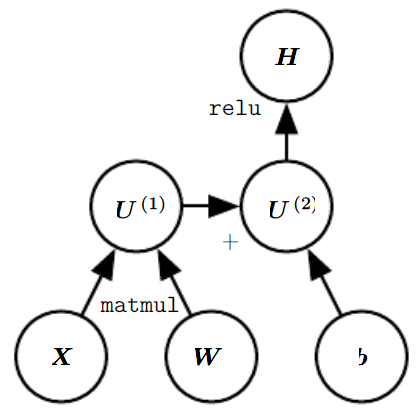

[圖源](https://www.deeplearningbook.org/)

In [ ]:
param = torch.tensor([2.0], requires_grad=True)
param, param.grad

(tensor([2.], requires_grad=True), None)

In [ ]:
v1 = param**3
v1 # 顯示計算出的值，與供需要計算 gradient 時使用的 gradient function

tensor([8.], grad_fn=<PowBackward0>)

- `tensor.clone()`：複製 tensor，不共享資料，但存在 computational graph (identity mapping)
- `tensor.detach()`：返回一個從當前 computational graph 分離下來的、新的 tensor，和原始 tensor 共用同樣的資料

In [ ]:
v2 = param.detach()**2
v2

tensor([4.])

In [ ]:
v3 = v1 + v2
v3

tensor([12.], grad_fn=<AddBackward0>)

`tensor.backward()`：意謂 backward propagation，如果計算的函數是可微的，自動計算對 parameter 的 gradient (反向遍歷 computational graph)，累積寫入 `parameter.grad`

一系列的函數呼叫鏈代表了函數合成 (composition)，PyTorch 在幕後使用微積分的 chain rule 來計算 gradient

In [ ]:
v3.backward()
param.grad, param.grad.data # 3 * param**2

(tensor([12.]), tensor([12.]))

再做計算時，gradient 又累積上去

In [ ]:
v1 = param**3
v2 = param.detach()**2
v3 = (v1 + v2).sum()
v3.backward()
param.grad

tensor([24.])

`tensor.grad.zero_()`：in-place 重置 gradient
- 另種方法是 `parameter.grad = None`，[參考](https://discuss.pytorch.org/t/in-optimizer-zero-grad-set-p-grad-none/31934)

PyTorch 中名稱以 _ 結尾的方法表示 in-place (就地操作直接更改 tensor 的內容，而不複製它) 修改物件

In [ ]:
param.grad.zero_()
param.grad

tensor([0.])

重新開始累積 gradient

In [ ]:
v1 = param**3
v2 = param.detach()**2
v3 = v1 + v2
v3.backward()
param.grad

tensor([12.])

- `tensor.data`：tensor 的內部數據，修改不會參與 gradient 計算，[已廢棄](https://discuss.pytorch.org/t/the-difference-between-torch-tensor-data-and-torch-tensor/25995)
- `torch.no_grad()`：context-manager，with block 內不參與計算 gradient，常用於 SGD 下 parameter 的調整
```python
with torch.no_grad(): param -= 0.1 * param.grad
```

不可微分的例子

In [ ]:
w1 = torch.tensor([1.], requires_grad=True)
w2 = w1**2
print(w2)
w3 = (w2>2.0).float().mean()
print(w3)
w3.backward()

tensor([1.], grad_fn=<PowBackward0>)
tensor(0.)


RuntimeError: ignored

## gradient descent

### 概述

自然現象常用數學函數來近似；如 supervised learning 本質是 function approximation，找到近似的函數滿足輸入、輸出的關係
- function model：對觀測值的數學建模
- parameter：該 model 界定特定 function 的參數
- loss function：估計 model (函數) 的近似程度有多好？

learning 是不斷調整 parameter，讓 loss 最小化的過程，使找到最適切的 model

gradient descent 為一種微積分的技巧，快速調整 parameter

### metric vs. loss

- metric
  - 根據 model prediction 和 validation set label 計算的數字，目的是評估 model 有多好
  - classification model 常用 accuracy 為 metric
  - 推動人的理解
  - 在每個 epoch 結束時印出，告訴我們模型的表現如何
- loss
  - 推動自動化學習
  - 必須是一個具有有意義的微分的函數，不能太平坦，必須相當平滑
  - 計算數據集中每個資料的 loss，在一個 epoch 結束時，打印 loss 的平均值

### norm

衡量距離 (相似度) 的方式：
- mean absolute difference (平均絕對偏差) ($L^{1}$ norm)
- root mean squared error (RMSE) (均方根誤差) ($L^{2}$ norm)

$L^{p}$ norm：
$\left\|x\right\|_{p}=\left(\sum_{i}^{}\left|x_{i}\right|^{p}\right)^{\frac{1}{p}}$

### 演算法

$\nabla loss=\begin{bmatrix}
{\frac{\partial loss}{\partial param_{1}}}\\
{\frac{\partial loss}{\partial param_{2}}}\\
{...}\\
{\frac{\partial loss}{\partial param_{d}}}\\
\end{bmatrix}$

gradient (梯度)：包含各 parameter 微分/改變率/斜率的向量
- 分量的符號：當對應 parameter 增加時，會增加/減少 loss
- 分量的大小：當對應 parameter 增加時，loss 變化的速率

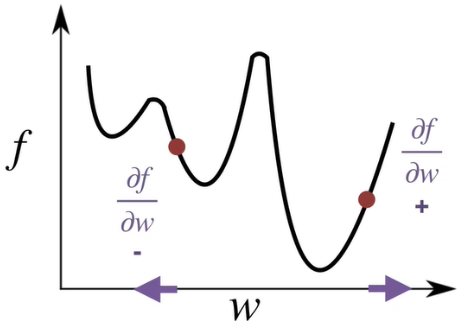

[圖源](https://www.coursera.org/specializations/reinforcement-learning#courses)

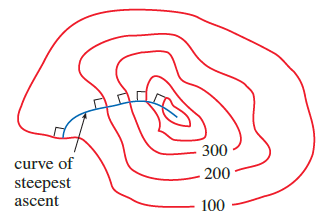

[圖源](https://www.amazon.com/Calculus-Early-Transcendentals-James-Stewart/dp/1337613924)

gradient 給出改變率最大 (最陡) 的方向，為找極值時的一個效能優化的技巧

gradient descent：重複調整 parameter (stepping parameters、optimization step) 為 gradient 的反方向 (negative gradient)，以降低 loss

$param_{t+1}=param_{t}-lr*\nabla loss$

learning rate (LR)：hyperparameter (用於計算 parameter 的參數)，控制單步調參的幅度
- 太大：可能發散，或來回反彈使得收斂很慢
- 太小：可能收斂太慢
- 通常在訓練時，learning rate 會逐步調降，以防在極值的近旁由於步長相對太大還是一直跨過極值

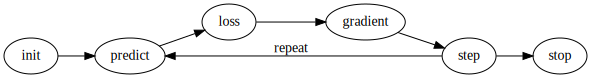

In [ ]:
# @title
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

依據 training/validation loss、metric 決定何時停止

演算法：
```python
for x, y in dl:
  pred = model(x)
  loss = loss_func(pred, y)
  loss.backward()
  parameters -= lr * parameters.grad
```

### BGD vs. SGD vs. MBGD

- batch gradient descent (BGD)
  - $param_{t+1}=param_{t}-lr*\frac{1}{n}\sum_{i=1}^{n}\nabla loss\left(x_{i}\right)$
  - 計算整個數據集並取平均值
  - 需要很長時間
- stochastic gradient descent (SGD)
  - $param_{t+1}=param_{t}-lr*\nabla loss\left(x_{t}\right)$
  - 計算單個數據
  - gradient 不精確、不穩定，適合 online learning
- mini-batch gradient descent (MBGD)
  - $param_{t+1}=param_{t}-lr*\frac{1}{m}\sum_{i=1}^{m}\nabla loss\left(x_{i}\right)$
  - 計算 batch size 個數據並取平均值
    - 某種意義上是 Monte Carlo 方法：用樣本平均值來近似期望值
    - $\sum_{x}^{}p\left(x\right)f\left(x\right)=E_{p}\left[f\left(x\right)\right]$
  - 相較於 SGD 的優點是，可以利用 GPU

### mini-batch

PyTorch/fastai `DataLoader` 可以為每個 epoch，隨機打亂數據集，然後創建 mini-batch，以增加推廣性
- 接收 python collection，轉為 iterator 來迭代 batch

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([10, 13,  6,  7,  5]),
 tensor([ 3, 11,  8, 14,  4]),
 tensor([12,  1,  9,  0,  2])]

`enumerate()`：將一個可遍歷的 object，組合為索引陣列

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

PyTorch `Dataset` 為 training/validation example tuple (x, y) 的列表

將 `DataSet` 傳遞給 `DataLoader` 時，將返回許多 training/validation example tuple batch

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([11,  0, 10, 23, 13,  3]), ('l', 'a', 'k', 'x', 'n', 'd')),
 (tensor([19, 17,  2,  4, 16, 12]), ('t', 'r', 'c', 'e', 'q', 'm')),
 (tensor([25,  6,  9,  5, 24, 21]), ('z', 'g', 'j', 'f', 'y', 'v')),
 (tensor([18,  7, 15,  8, 22,  1]), ('s', 'h', 'p', 'i', 'w', 'b')),
 (tensor([14, 20]), ('o', 'u'))]

## neural network

neural network：
- parameter (weight、bias)：model 的參數，隨機初始、待優化
- activation：透過 linear/nonlinear layer 計算的數字
	- 輸入、parameter 的線性轉換，再套用非線性轉換 (activation function)
	```
	ReLU(input * weight + bias)
	```

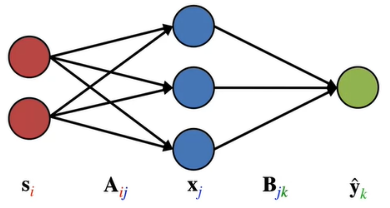

([圖源](https://www.coursera.org/specializations/reinforcement-learning))

optimizer：每個 optimization step，調整 parameter，降低 loss；基本是執行 gradient descent

## activation function

- nonlinear：才能組成非線性複雜函數
- differentiable：允許單點不可微分 (如 ReLU)

### rectified linear unit (ReLU)

rectified linear unit (ReLU)：用零替換每個負數，可用 PyTorch `F.relu`
- max function 像是一個 if statement

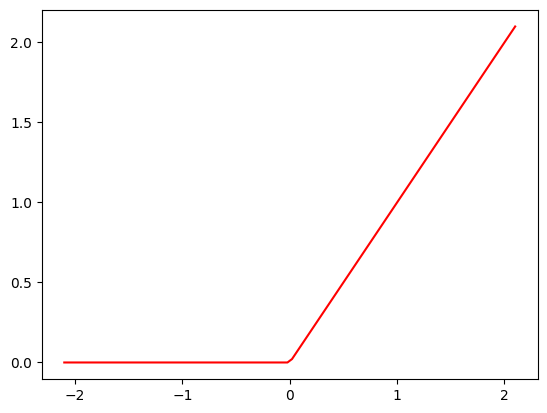

In [26]:
plot_function(F.relu)

`torch.clip()`：等同 torch.clamp()，將值 clamp 到 [min, max]

In [27]:
def rectified_linear(m,b,x):
  y = m*x+b # linear
  return torch.clip(y, 0.) # 最小值 0

In [28]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
  plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

一系列任意數量的 linear layer 可以替換為具有不同 parameter 的單個 linear layer
- 兩個線性函數的合成是另一個線性函數

將任意數量的 ReLU 相加，可以得到一個任意彎折的函數，來近似任何函數
- universal approximation theorem：對於任何任意曲折的函數，可以將其近似為一堆連接在一起的短線段

可以擴展到輸入為多維的情況下，以足夠多數量的 ReLU 來近似超曲面

In [29]:
def double_relu(m1,b1,m2,b2,x):
  return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
  plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…


deep learning：利用 gradient descent 來調整 parameter、降低 loss，使得彎曲型態的 function model 近似於數據的生成函數

### sigmoid

平滑輸入，輸出 [0, 1] 的值，可用於機率估計

In [30]:
def sigmoid(x): return 1/(1+torch.exp(-x))

`torch.sigmoid`：PyTorch 的版本，效能較好

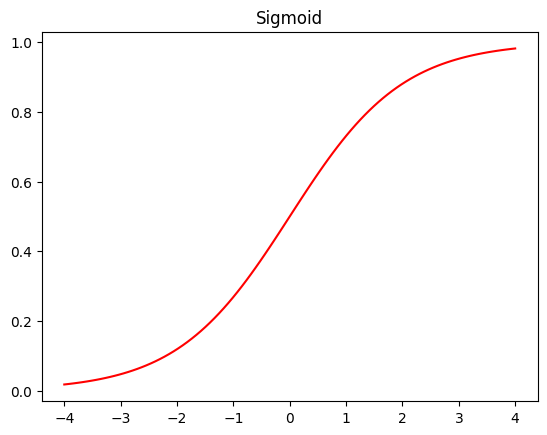

In [31]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

# pet breed classifier - training

## 下載寵物的圖

[fastai dataset](https://docs.fast.ai/data.external.html#datasets)

In [ ]:
path = untar_data(URLs.PETS)/'images'

## 訓練

`ImageDataLoaders.from_name_func()`：使用 `label_func` 從 `path` 中的 `fname` 名稱屬性創建 `DataLoader`

`RegexLabeller()`：使用正規表示式來設定 label

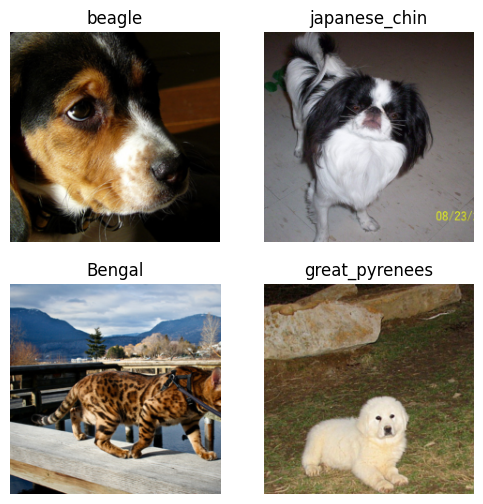

In [ ]:
dls = ImageDataLoaders.from_name_func('.',
  get_image_files(path), valid_pct=0.2, seed=42,
  label_func=RegexLabeller(pat = r'^([^/]+)_\d+'), # 如 cat_01.jpg 會提取出 cat
  item_tfms=Resize(224))
dls.show_batch(max_n=4)

metric `error_rate`：1 - accuracy

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 54.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.501200,0.291742,0.100812,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.490865,0.299203,0.093369,00:48
1,0.300659,0.224619,0.075101,00:49
2,0.139878,0.207118,0.066306,00:48


## 訓練調優

In [ ]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

在 mixed precision 訓練中，model 的 parameter、計算都使用低精度的浮點數，以加速 model 訓練、節省記憶體

`learner.to_fp16()`：設定使用 float16 mixed precision

In [ ]:
learn = vision_learner(dls, 'convnextv2_tiny', metrics=error_rate).to_fp16()
learn.fine_tune(3)
# 可以看到比 resnet34 訓練更久, 但更準

epoch,train_loss,valid_loss,error_rate,time
0,0.885414,0.207752,0.069012,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.245664,0.156064,0.053451,01:11
1,0.175251,0.141422,0.044655,01:12
2,0.101368,0.129392,0.046008,01:11


## 儲存

In [ ]:
learn.export('model.pkl')

# pet breed classifier - inference

[pet breed classifier](https://huggingface.co/spaces/spencer23/pets)

In [ ]:
#|default_exp app

## 載入模型來推理

In [ ]:
#|export
from fastai.vision.all import *
import gradio as gr

注意此專案需要一張範例圖片 `basset.jpg`

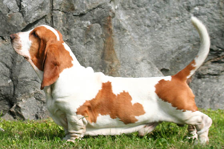

In [ ]:
im = PILImage.create('basset.jpg')
im.thumbnail((224,224))
im

In [ ]:
#|export
learn = load_learner('model.pkl')

In [ ]:
learn.predict(im)

('basset_hound',
 tensor(14),
 tensor([7.5443e-06, 5.1741e-05, 5.7549e-07, 4.1042e-08, 1.6259e-06, 7.6028e-06,
         8.6673e-06, 3.1610e-06, 9.4127e-07, 6.3964e-07, 1.3192e-06, 9.5642e-07,
         9.8660e-07, 3.4634e-05, 9.9976e-01, 3.6707e-05, 1.4890e-06, 1.5779e-07,
         2.0130e-05, 9.3007e-07, 1.8783e-06, 1.3870e-06, 2.6893e-06, 8.4041e-07,
         4.9065e-06, 3.6174e-06, 7.5684e-07, 7.1714e-07, 2.4276e-06, 4.4328e-06,
         1.0985e-05, 4.8861e-06, 2.6183e-06, 1.8407e-05, 1.0983e-06, 1.9212e-07,
         1.3432e-06]))

- `map()`：將 list 的每一個元素套用函式轉換，回傳轉換後的元素 list
- `zip()`：將兩個 list 的對應元素組合，回傳 tuple list
- `dict()`：可以傳入 tuple list 來創建 dictionary

In [ ]:
#|export
categories = learn.dls.vocab
def classify_image(img):
  pred, pred_idx, probs = learn.predict(img)
  return dict(zip(categories, map(float, probs)))

In [ ]:
classify_image(im)

{'Abyssinian': 7.5443476816872135e-06,
 'Bengal': 5.174141188035719e-05,
 'Birman': 5.754879452979367e-07,
 'Bombay': 4.10418508067778e-08,
 'British_Shorthair': 1.6258900359389372e-06,
 'Egyptian_Mau': 7.602771802339703e-06,
 'Maine_Coon': 8.667349902680144e-06,
 'Persian': 3.1610331916454015e-06,
 'Ragdoll': 9.412657391294488e-07,
 'Russian_Blue': 6.396350613613322e-07,
 'Siamese': 1.3191694279157673e-06,
 'Sphynx': 9.564205356582534e-07,
 'american_bulldog': 9.865999572866713e-07,
 'american_pit_bull_terrier': 3.463387110969052e-05,
 'basset_hound': 0.9997569918632507,
 'beagle': 3.6707093386212364e-05,
 'boxer': 1.488991301812348e-06,
 'chihuahua': 1.5778763895468728e-07,
 'english_cocker_spaniel': 2.0130197299295105e-05,
 'english_setter': 9.300672445533564e-07,
 'german_shorthaired': 1.8782930055749603e-06,
 'great_pyrenees': 1.3870072734789574e-06,
 'havanese': 2.6893301310337847e-06,
 'japanese_chin': 8.404140316997655e-07,
 'keeshond': 4.9065092753153294e-06,
 'leonberger': 3.

## Gradio 界面

In [ ]:
#|export
image = gr.components.Image(shape=(192,192))
label = gr.components.Label()
examples = ['basset.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


## 導出 .py

由於在 colab 中我無法確定 notebook 所在路徑，這邊先手動下載 .ipynb，再把 .ipynb 上傳到虛擬機內，再執行導出的命令

In [ ]:
nbdev.export.nb_export('03.ipynb', 'app')

## model.pkl 解析

In [ ]:
m = learn.model
m

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): GlobalResponseNormMlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (grn): GlobalResponseNorm()
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop_p

In [ ]:
l = m.get_submodule('0.model.stem.1') # architecture, parameters
list(l.parameters())

[Parameter containing:
 tensor([ 4.9252e+00, -8.8931e-03,  1.1225e+00,  3.4760e-01,  2.0027e-01,
          4.7673e-01, -7.8531e-03,  1.9138e+00,  3.0265e+00,  1.5554e+00,
          5.8055e-01,  3.0272e-03,  3.3812e+00,  1.2345e+00, -5.0285e-03,
          2.1274e+00,  1.7267e+00,  7.8180e-01,  2.3206e+00,  3.1614e+00,
          1.6727e+00,  1.3218e+00,  3.6923e-01,  2.2163e+00,  1.8394e-01,
          1.5454e-01,  1.8188e+00, -7.2885e-03,  2.3786e+00,  3.6737e+00,
          4.0175e-01,  1.3288e-02,  3.6669e-01,  1.2017e+00,  7.2605e-01,
          2.8256e-01,  2.4172e+00,  3.1015e-01,  7.0893e-01,  6.3397e-01,
          7.8387e-01,  1.5047e-03,  2.8075e-01,  5.4662e-01,  8.0843e-01,
          3.3405e-01,  7.9724e-01,  6.0152e-01,  1.9911e-01,  3.4873e-01,
          2.2384e+00,  9.4173e-03,  1.1588e+00, -4.0368e-03,  3.2383e+00,
          5.8471e-01,  2.2201e-01,  4.1921e+00,  2.9326e-01,  8.4095e-01,
         -1.7223e-03,  6.5935e-03,  6.6517e-01,  2.4060e-01,  1.2574e+00,
          2.749

In [ ]:
l = m.get_submodule('0.model.stages.0.blocks.1.mlp.fc1')
list(l.parameters())

[Parameter containing:
 tensor([[-0.0546, -0.0275, -0.0114,  ...,  0.0161,  0.0374, -0.0029],
         [ 0.0018, -0.0520,  0.0144,  ..., -0.0254, -0.0422,  0.0050],
         [-0.0104,  0.0004, -0.0077,  ..., -0.0393, -0.0060, -0.0004],
         ...,
         [-0.0041, -0.0124, -0.0329,  ..., -0.0213, -0.0050,  0.0024],
         [ 0.0305,  0.0005,  0.0191,  ...,  0.0493, -0.0119, -0.0039],
         [-0.0076,  0.0014, -0.0084,  ...,  0.0120,  0.0138,  0.0040]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.8709, -0.7155, -1.0197, -1.0518, -0.5569, -0.8994, -0.7451, -1.1259,
         -0.9347, -1.1853, -0.8043, -0.7971,  0.1005, -1.5094, -0.9241, -0.6479,
          0.6849, -1.1375, -0.0262, -1.0960, -0.8624, -0.7149, -0.6821,  0.2149,
         -1.6132, -0.6694, -0.4569, -0.0345, -0.6727, -0.4704, -0.8045,  0.0036,
         -0.4164,  1.1498, -0.9720, -0.2355, -0.8717, -1.0912, -0.5574,  0.1454,
         -1.3999,  0.1280, -0.4640, -0.5791,  0.0431, -1.1843,  0.1650, -1.1268

# gradient descent 範例 - 二次函數

## function model

`partial()`：對 function 部分應用給定參數，回傳特製後的 function

In [ ]:
# 二次函數的一般式
def quad(a, b, c, x): return a*x**2 + b*x + c

def mk_quad(a,b,c): return partial(quad, a,b,c) # 應該也可用閉包實現

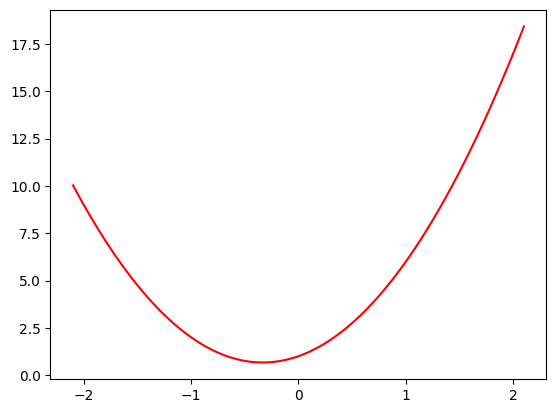

In [ ]:
f = mk_quad(3, 2, 1)
plot_function(f)

## 模擬由二次函數產生的數據

`normal(scale, size)`：由 normal (Gaussian) distribution 產生數值
- scale：standard deviation
- size：數值 shape

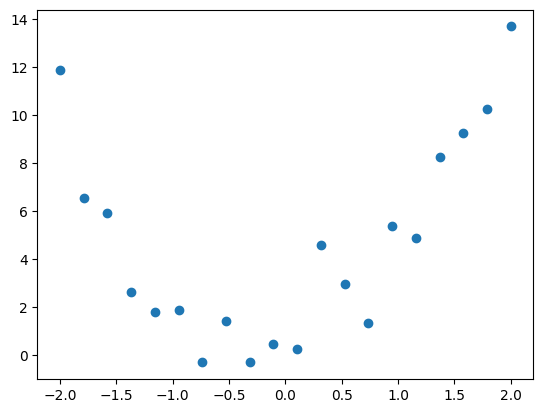

In [ ]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None] # 20x1
y = add_noise(f(x), 0.15, 1.5)

plt.scatter(x,y); # 內部會將 tensor 轉為 NumPy array

## 手動近似函數

In [ ]:
# mean squared error (MSE)
def mse(preds, acts): return ((preds-acts)**2).mean()

`tensor.item()`：取得標準的 python number

In [ ]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
  f = mk_quad(a,b,c)
  plt.scatter(x,y)
  loss = mse(f(x), y)
  plot_function(f, ylim=(-3,12), title=f"MSE: {loss.item():.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## 自動近似函數

In [ ]:
# 以 model parameter 參數化的 loss function
def quad_mse(params):
  f = mk_quad(*params)
  return mse(f(x), y)

In [ ]:
abc = torch.tensor([1.5,1.5,1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [ ]:
loss = quad_mse(abc) # parameter 參與計算
loss

tensor(5.4892, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()
abc.grad

tensor([-7.0908,  1.0602, -1.8620])

In [ ]:
with torch.no_grad(): # 內部調參不計算 gradient
  abc -= abc.grad * 0.01
  loss = quad_mse(abc)
print(f'loss={loss.item():.2f}') # 應該會降低 loss

loss=4.96


此處似乎漏掉清除 grad 的步驟 ([lesson kaggle](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work?scriptVersionId=104206956&cellId=49))

In [ ]:
# 簡易 optimizer
for i in range(5):
  loss = quad_mse(abc)
  loss.backward()
  with torch.no_grad():
    abc -= abc.grad*0.01
    # abc.grad = None
  print(f'step={i}; loss={loss.item():.2f}')
abc

step=0; loss=4.96
step=1; loss=4.09
step=2; loss=3.17
step=3; loss=2.51
step=4; loss=2.32


tensor([2.6076, 1.2985, 1.7369], requires_grad=True)

# gradient descent 範例 - 雲霄飛車的速率函數

## 時間-速率曲線

`torch.arange()`：回傳 `step` 間隔的 rank-1 tensor

In [ ]:
torch.manual_seed(42)

time = torch.arange(0, 20).float();
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

`torch.randn()`：回傳一個標準常態分佈的 tensor

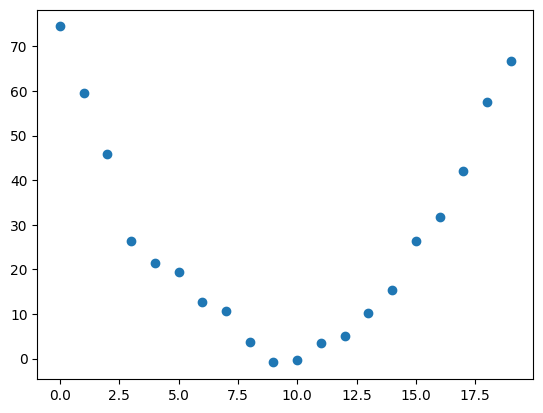

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1 # 加入隨機 noise
plt.scatter(time,speed);

## function model、loss

In [ ]:
# 二次函數
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

# mean squared error
def mse(preds, targets): return ((preds-targets)**2).mean()

## 初始 parameter

In [ ]:
params = torch.randn(3).requires_grad_()

In [ ]:
#hide
orig_params = params.clone()

## 計算 prediction

In [ ]:
preds = f(time, params)

matplotlib 的元素：
- figure：畫布
- axes：figure 中一個元素 (圖片) 的整套座標軸

`matplotlib.pyplot.subplots()`：創建 figure、subplots，回傳 figure、axes

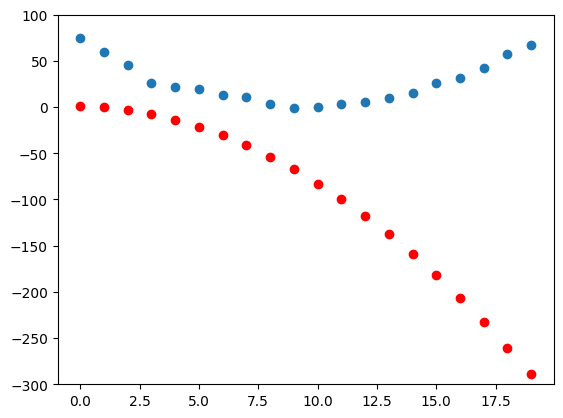

In [ ]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)

show_preds(preds)

## 計算 loss

In [ ]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

## 計算 gradient

In [ ]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

## step parameter

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data # 使用 tensor.data 避免參與 gradient 計算
params.grad = None # 避免再次累積 grad

In [ ]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

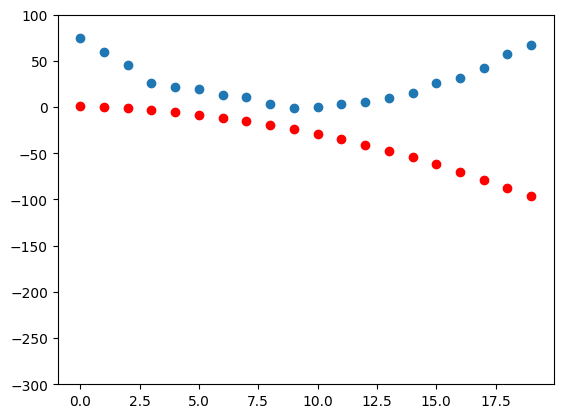

In [ ]:
show_preds(preds)

In [ ]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

## 重複調參

一步步找尋更適切的二次函數

In [ ]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [ ]:
#hide
params = orig_params.detach().requires_grad_()

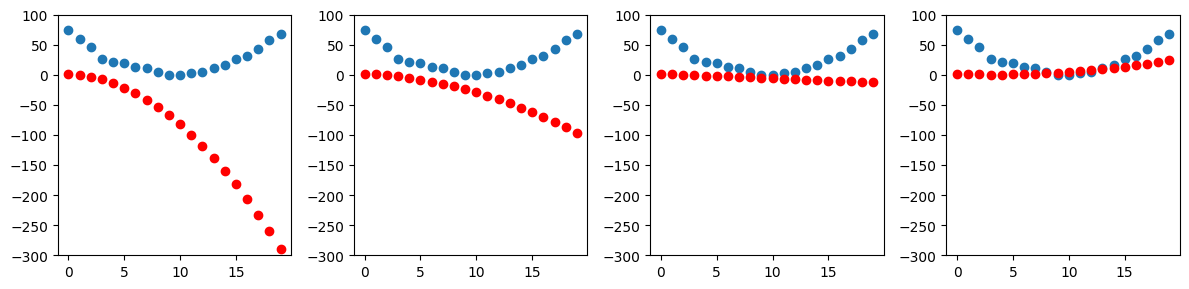

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

# titanic sheet

做 tabular analysis，由鐵達尼號的乘客資料，預測是否存活

[sheet](https://docs.google.com/spreadsheets/d/1SPsZ-w-uKDhSiVD-bIELHb7hmtaHgZK-OarLZ1X8sZ0/edit?usp=sharing)

流程：
- 刪除不重要的欄位，移除 missing value 的資料
- 把欄位值轉為數字
	- one-hot encoding
		- 移除一欄資料
	- Pclass、Embarked、Sex
- 正規化欄位範圍
	- Age
- 將極端分布的欄位取 log
	- Fare
- 加入一欄都是 1 的資料，配合 bias
	- Ones
- 套用 model 計算 prediction
- Solver
	- Set Objective：mean squared error
	- By Changing Variable Cells

model：
- linear
	- $features * weights + bias$
- nnet
	- $ReLU(features * weights1 + bias1) + ReLU(features * weights2 + bias2)$
	- 非線性
- mmult
	- $ReLU(featuresMatrix * weightsMatrix + biasMatrix)$
	- 簡潔、效率更好

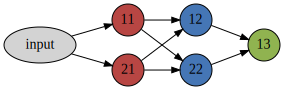

In [ ]:
# @title
gv('''
node [shape=circle fixedsize=true width=0.45 style=filled]
edge [arrowsize=0.8]
input [shape=ellipse width=1]
11,21 [style=filled fillcolor="#b84643"]
12,22 [style=filled fillcolor="#4576b5"]
13 [style=filled fillcolor="#90b350"]
input->11
input->21
11->12
21->12
11->22
21->22
12->13
22->13
''')

# 3, 7 classifier

## MNIST dataset

MNIST：著名的資料集，包含手寫數字

training/validation set 放在不同資料夾

In [ ]:
matplotlib.rc('image', cmap='Greys')

path = untar_data(URLs.MNIST_SAMPLE)
path.ls() # 回傳 L

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

其下不同 label 放在不同資料夾

In [ ]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

內含多個圖檔

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

Python Imaging Library (PIL)：操作、查看圖像的最廣泛使用的 python package

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path) # PIL image class
im3

處理圖像資料時，多轉為 NumPy array、PyTorch tensor

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

`DataFrame`：矩形數據表

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## baseline model: pixel similarity

對所有 3, 7 的圖像的每一個對應的 pixel 取平均值，結果稱為 ideal 3, 7

對圖像進行分類時，看與哪個 ideal digit 更相似

memory-based，沒有參數化的函數型式；事實上不需要 validation set

### training set 轉為 tensor

In [ ]:
three_tensors = [tensor(Image.open(o)) for o in threes] # list comprehension 創建 tensor list
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

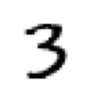

In [ ]:
show_image(three_tensors[1]); # tensor 需要使用 fastai show_image 來顯示

`torch.stack()`：沿新 dimension 連接一系列 tensor
- dim: 要新增的 dimension

PyTorch 中的一些操作 (如取平均值)，要求將整數類型轉換為浮點數類型

`tensor.shape`：取出每一 axis 的長度

In [ ]:
stacked_threes = torch.stack(three_tensors).float()/255 # pixel 的浮點數值, 常正規化為 [0,1]
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape # 圖像個數x高x寬

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

`tensor.ndim`：取得 dimension 的數量，即 rank

In [ ]:
len(stacked_threes.shape), stacked_threes.ndim

(3, 3)

### 計算 ideal 3, 7

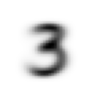

In [ ]:
mean3 = stacked_threes.mean(0) # 沿著 dimension 0 取平均值
show_image(mean3);

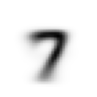

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

### 計算 norm

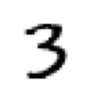

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr # 看起來都比較接近 ideal 3

(tensor(0.1586), tensor(0.3021))

`torch.nn.functional`：提供多種 loss function (如 mean absolute value、mean squared error)

In [ ]:
F.l1_loss(a_3,mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### validation set 轉為 tensor

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### 計算 accuracy

使用 mean absolute error 來計算相似度

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # 在最後兩個 axis 上計算平均值

mnist_distance(a_3, mean3)

tensor(0.1114)

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1383, 0.1204, 0.1170,  ..., 0.1355, 0.1305, 0.1187]),
 torch.Size([1010]))

In [ ]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## SGD - linear classifier

引入參數化的函數型式，使可以透過 SGD 訓練學習

true label：
- 3：1
- 7：0

function model：
- 估計圖像是 3 的機率：$pixels * weights + bias$

### 整理 training、validation set

- `torch.cat()`：串接 tensor 列表
- `tensor.view()`：將 tensor 改變形狀；-1 表示由其他 dimension 推斷大小
- `tensor.unsqueeze()`：新增一個大小為 1 的 dimension

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) # 一張圖用一個向量表示
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # label
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
dset = list(zip(train_x,train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

### 初始 parameter

In [ ]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [ ]:
torch.manual_seed(42)

weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [ ]:
bias = init_params(1)
bias.shape

torch.Size([1])

In [ ]:
(train_x[0]*weights.T).sum() + bias # 計算一張圖的 prediction

tensor([-6.2330], grad_fn=<AddBackward0>)

### linear function model

In [ ]:
def linear1(xb): return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

### 計算 accuracy

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [ ]:
corrects.float().mean().item()

0.5379961133003235

使用 accuracy 當作 loss function 的問題是：
- 衡量 model 的好壞太粗略
- weight 的微小變化不太可能導致任何 prediction 發生變化，gradient (accuracy 的變化率) 總是 0

In [ ]:
with torch.no_grad(): weights[0] *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

額外的實驗：調整 bias 是會影響 accuracy 的

In [ ]:
with torch.no_grad(): weights[0] *= 1.5
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

In [ ]:
with torch.no_grad(): bias *= 1.5
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5395289063453674

### MNIST loss function

In [ ]:
trgts = tensor([1,0,1]) # true label 3, 7, 3
prds = tensor([0.9, 0.4, 0.2]) # 高信心 (0.9) 預測第一個是 3, 輕微信心 (0.4) 預測第二個是 7, 中等信心 (0.2) (錯誤) 預測最後一個是 7

`torch.where(a,b,c)`：類似 list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`

In [ ]:
# 假設 prediction 在 [0, 1]
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

當 prediction 更準確，loss 較小
- 準確的 prediction 更有信心
- 不准確的 prediction 不太有信心

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts) # 對第三個預測更準

tensor(0.2333)

正規化 prediction，較高的 prediction 對應於較高的置信度

In [ ]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

### 完整流程

In [ ]:
torch.manual_seed(42)

weights = init_params((28*28, 1))
bias = init_params(1)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

def train_epoch(model, lr, params):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [ ]:
lr = 1.
params = weights, bias
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.7303 0.8505 0.9008 0.9291 0.9389 0.9443 0.9526 0.9545 0.9589 0.9613 0.9623 0.9623 0.9633 0.9638 0.9648 0.9662 0.9667 0.9672 0.9672 0.9677 

## optimizer

PyTorch `nn.Linear` module：計算 linear activation
- in_features：輸入的大小
- out_features：輸出的大小

In [ ]:
linear_model = nn.Linear(28*28, 1)
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [ ]:
class BasicOptim:
  def __init__(self, params, lr):
    self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [ ]:
validate_epoch(linear_model)

0.5254

In [ ]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

0.4932 0.8159 0.8501 0.914 0.9321 0.9463 0.9555 0.9634 0.9658 0.9673 0.9692 0.9712 0.9736 0.9746 0.9761 0.9765 0.9775 0.9775 0.978 0.978 

fastai `SGD` class：預設做跟 BasicOptim 一樣的事

In [ ]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7207 0.8589 0.9179 0.936 0.9512 0.9565 0.9629 0.9658 0.9678 0.9702 0.9707 0.9741 0.9751 0.9761 0.9775 0.9775 0.978 0.9785 0.9785 

fastai `Learner.fit` 可以取代 train_model，完成多 epoch 的訓練

先創建 `DataLoaders`

In [ ]:
dls = DataLoaders(dl, valid_dl)

不使用應用 (如 cnn_learner) 來創建 learner 時，需要傳遞給它所有資訊

In [ ]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636288,0.503516,0.495584,00:00
1,0.540942,0.151796,0.882237,00:00
2,0.197494,0.194780,0.818940,00:00
3,0.086165,0.110575,0.910206,00:00
4,0.045172,0.079522,0.931305,00:00
5,0.029207,0.063207,0.947498,00:00
6,0.022659,0.053198,0.955348,00:00
7,0.019762,0.046603,0.961236,00:00
8,0.018305,0.041993,0.965162,00:00
9,0.017439,0.038599,0.967125,00:00


## neural network

In [ ]:
def simple_net(xb):
  res = xb@w1 + b1 # linear layer
  res = res.max(tensor(0.0)) # nonlinearity、activation function
  res = res@w2 + b2 # linear layer
  return res

In [ ]:
torch.manual_seed(42)

w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

PyTorch 提供簡單建立 neural network

- `nn.Sequential`：創建 module，該 module 將依次呼叫列出的每個 layer、函數
	- 由於是 module，可以獲取它的 parameter，將返回它包含的所有 module 的所有 parameter 列表
- `nn.ReLU`：PyTorch model，與 `F.relu` function 相同
	- 多數 model function 也有相同的 module 形式
	- 使用 `nn.Sequential` 時，需用 module 版本

In [ ]:
simple_net = nn.Sequential(
  nn.Linear(28*28, 30),
  nn.ReLU(),
  nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.289997,0.416602,0.504416,00:00
1,0.139187,0.217227,0.819921,00:00
2,0.077946,0.110834,0.921492,00:00
3,0.051940,0.075958,0.941609,00:00
4,0.039816,0.059922,0.956330,00:00
5,0.033563,0.050830,0.963690,00:00
6,0.029928,0.045051,0.965162,00:00
7,0.027539,0.041075,0.965653,00:00
8,0.025803,0.038160,0.968106,00:00
9,0.024449,0.035923,0.969087,00:00


訓練過程記錄在 `learn.recorder` 中，`values` attribute 儲存數值列表

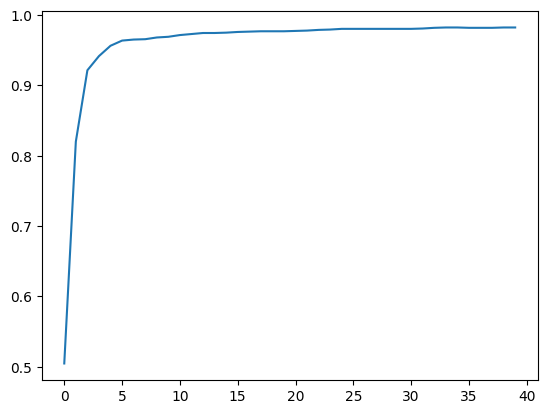

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2] # 最後的 accuracy

0.98233562707901

## 深層網路

深層網路需要的 parameter 較少就可以達到不錯的結果，訓練更快、記憶體用量小；但較難優化 parameter

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.095411,0.015984,0.996075,03:27


# 大大的補充

- optimizer基本上就是改良過的gradient decent方法
- 多數的分類metrics都沒辦法微分，所以會設計一些能微分的loss function
- 機器學習其中一個有難度的地方就是當設計新的loss function時，要證明它能引導model到它的訓練目標
- 同個模型可以混用activation function嗎?
  - 可以，但 hidden layer 常用 ReLU
- sigmoid和softmax通常用在最後一層，一個是二分類一個是多類別分類